In [1]:
import argparse
import json
import os
from glob import glob
from os.path import join as pjoin

import gurobi_logtools as glt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import interpolate

# Relative primal gap

In [2]:
class Exp_result:
    def __init__(self, test_logs_dir, TaskName, solver, exp_id, search, name, color, marker):
        self.result_dir = pjoin(test_logs_dir, TaskName, exp_id, solver, search)
        self.exp_id = exp_id
        self.search = search
        self.name = name
        self.color = color
        self.marker = marker
        self.n_infeasible = 0
        self.min_ys = []
        self.ys = []
        self.integrals = []

In [3]:
def get_x_y(file, p_bound, x_lim):
    result = glt.parse(file)
    nodelog_progress = result.progress("nodelog")
    if len(nodelog_progress) <= 1:
        return None, None
    nodelog_progress = nodelog_progress[["Incumbent", "Time"]].dropna()
    new_row = pd.DataFrame({'Incumbent': [p_bound], 'Time': [0]})
    df = pd.concat([new_row, nodelog_progress]).reset_index(drop=True)
    
    x = df["Time"].to_list()
    y = df["Incumbent"].to_list()
    
    xnew = np.arange(0, x_lim, 1)
    ynew = np.interp(xnew, x, y)
    min_y = np.min(y)
    
    df.drop_duplicates(['Time'], keep='last', inplace=True)
    df["dt"] = np.array(df["Time"].to_list()[1:] + [x_lim]) - df["Time"]
    df['area'] = df['Incumbent'] * df['dt']
    integral = df['area'].sum()
    
    return list(ynew), min_y, integral

In [15]:
x_lim = 1000
TaskName = "IP"
solver = "GRB"
# exp_list = [
#     ["240812-035802", "400_5_1", "PAS", "green", "-"],
#     ["240812-141737", "100_5_15", "Ours", "orange", "-"]
# ]
exp_list = [
    ["240831-162652", "100_5_15", "emb", "red", "-"],
    ["240831-203523", "100_5_15", "uniform", "green", ":"],
    ["240831-162625", "100_5_15", "normal", "orange", ":"],
    ["240831-162631", "100_5_15", "uniform_h", "green", "-"],
    ["240831-162646", "100_5_15", "normal_h", "orange", "-"],
    ["240831-165318", "100_5_15", "uniform_h2", "green", "-"],
    ["240831-165325", "100_5_15", "normal_h2", "orange", "-"],
    # ["240830-145728", "100_5_15", "xavier_uniform", "orange", "--"],
    # ["240829-223837", "100_5_15", "xavier_normal", "green", "--"],
    # ["240830-200428", "100_5_15", "kaiming_uniform", "orange", "-"],
    # ["240830-192414", "100_5_15", "kaiming_normal", "green", "-"],
    # ["240830-150012", "100_5_15", "kaiming_normal_4", "blue", "-"],
]

In [16]:
base_dir = "/mnt/disk1/thlee/MILP/pas/"
gt_logs_dir = pjoin(base_dir, "dataset")
test_logs_dir = pjoin(base_dir, "test_logs")
ins_dir = pjoin(base_dir, f"instance/{TaskName}/test")
grb_dir = pjoin(gt_logs_dir, TaskName, "test/logs")

ins_names = sorted(os.listdir(grb_dir))
ins_names = [ins.split(".")[0] for ins in ins_names]

exp_results = {exp_info[2]: Exp_result(test_logs_dir, TaskName, solver, *exp_info) for exp_info in exp_list}

In [17]:
feasible_ins, ins_bks, ys_grb, min_ys_grb, integrals_grb = [], [], [], [], []
n_infeasible = 0
for ins in ins_names:
    ins_json = pjoin(ins_dir, f"{ins}.json")
    ins_grb = pjoin(grb_dir, f"{ins}.mps.gz.log")

    with open(ins_json, "r") as file:
        data = json.load(file)
    p_bound = data["primal_bound"]
    y_grb, min_y_grb, integral_grb = get_x_y(ins_grb, p_bound, x_lim)
    
    is_infeasible = False
    for exp in exp_results.values():
        ins_path = pjoin(exp.result_dir, f"{ins}.log")
        exp.y, exp.min_y, exp.integral = get_x_y(ins_path, p_bound, x_lim)
        if exp.y is None:
            is_infeasible = True
            exp.n_infeasible += 1
            
    if is_infeasible:
        n_infeasible += 1
        continue
    
    ys_grb.append(y_grb)
    feasible_ins.append(ins)
    min_ys_grb.append(min_y_grb)
    integrals_grb.append(integral_grb)
    
    min_ys = []
    for exp in exp_results.values():
        exp.min_ys.append(exp.min_y)
        exp.ys.append(exp.y)
        exp.integrals.append(exp.integral)
        min_ys.append(exp.min_y)
    ins_bks.append(np.min([min_y_grb] + min_ys))
    
min_ys_grb = np.array(min_ys_grb)
ys_grb = np.array(ys_grb)
ins_bks = np.array(ins_bks).reshape([-1, 1])
integrals_grb = np.array(integrals_grb).reshape([-1, 1])

In [18]:
integrals_grb = integrals_grb - (ins_bks * x_lim)
print(f"integral of gurobi: {integrals_grb.mean():.1f}")

for exp in exp_results.values():
    exp.min_ys = np.array(exp.min_ys)
    exp.ys = np.array(exp.ys)
    exp.integrals = np.array(exp.integrals).reshape([-1, 1])
    exp.integrals = exp.integrals - (ins_bks * x_lim)
    print(f"integral of {exp.name}: {exp.integrals.mean():.1f}")

print(f"Total number of infeasible instances: {n_infeasible}")
r_gap_grb = np.abs(ys_grb - ins_bks) / np.abs(ins_bks)
mean_grb = r_gap_grb.mean(axis=0)
std_grb = r_gap_grb.std(axis=0)


for exp in exp_results.values():
    exp.r_gap = np.abs(exp.ys - ins_bks) / np.abs(ins_bks)
    exp.mean = exp.r_gap.mean(axis=0)
    exp.std = exp.r_gap.std(axis=0)
    print(f"number of infeasible of {exp.name}: {exp.n_infeasible}")

integral of gurobi: 2408.5
integral of emb: 1810.6
integral of uniform: 1219.5
integral of normal: 1385.1
integral of uniform_h: 1408.1
integral of normal_h: 1293.4
integral of uniform_h2: 1539.7
integral of normal_h2: 1444.1
Total number of infeasible instances: 0
number of infeasible of emb: 0
number of infeasible of uniform: 0
number of infeasible of normal: 0
number of infeasible of uniform_h: 0
number of infeasible of normal_h: 0
number of infeasible of uniform_h2: 0
number of infeasible of normal_h2: 0


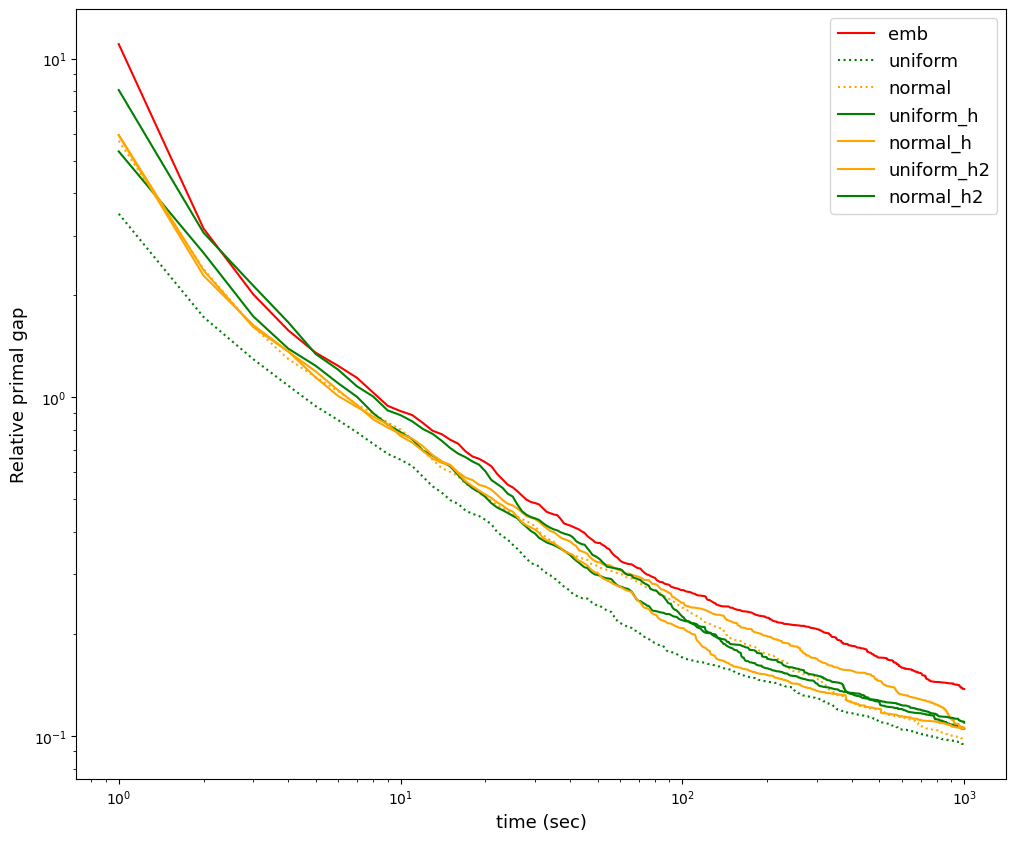

In [19]:
plt.figure(figsize=(12, 10))
xnew = np.arange(1, x_lim+1, 1)
# plt.plot(xnew, mean_grb, "-", label="Gurobi", color="gray")
# plt.fill_between(xnew, ys_grb - std_grb, ys_grb + std_grb, alpha=0.2)

for exp in exp_results.values():
    plt.plot(xnew, exp.mean, exp.marker, label=exp.name, color=exp.color)
    # plt.fill_between(xnew, exp.ys - exp.std, exp.ys + exp.std, alpha=0.2)

# plt.xlim((10, 1000))
# plt.xlim((1, 600))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("time (sec)", fontsize=13)
plt.ylabel("Relative primal gap", fontsize=13)
# plt.title(f"{par}_{d_type}")
plt.legend(fontsize=13)
plt.show()

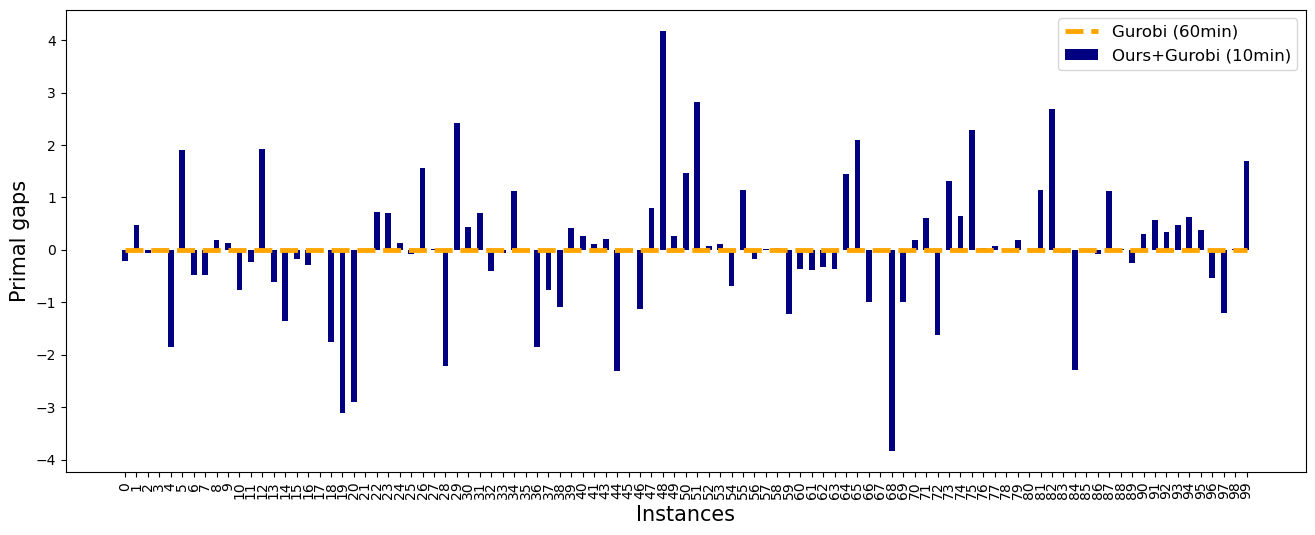

In [20]:
ins_name = np.array([int(ins.split("_")[-1]) for ins in feasible_ins]) - 10000
x = np.arange(len(ins_name))  # x locations for the groups

ys_grb = min_ys_grb - min_ys_grb
ys = exp_results["Ours"].min_ys - min_ys_grb

plt.figure(figsize=(16, 6))
plt.bar(x, ys, width=0.5, label="Ours+Gurobi (10min)", color="navy")
plt.plot(x, np.zeros(len(ys)), "--", label="Gurobi (60min)", color="orange", linewidth=3.5)
plt.xlabel("Instances", fontsize=15)
plt.ylabel("Primal gaps", fontsize=15)
# plt.title('Bar chart with standard deviation')
plt.xticks(x, ins_name, rotation=90, fontsize=10)
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [164]:
for par in params:
    ys_dict[par] = {}
    for d_type in datatypes:
        dir_path = os.path.join(base_dir, par, d_type)
        ys_dict[par][d_type] = get_x_y(dir_path)

In [133]:
gurobi_train_path = "/mnt/disk1/thlee/MILP/pas/dataset/CJ/train/logs"
gurobi_val_path = "/mnt/disk1/thlee/MILP/pas/dataset/CJ/val/logs"
xnew = np.arange(1, 600, 1)

In [167]:
train_y = get_x_y(gurobi_train_path)
val_y = get_x_y(gurobi_val_path)
y = {}
y["train"] = train_y
y["val"] = val_y

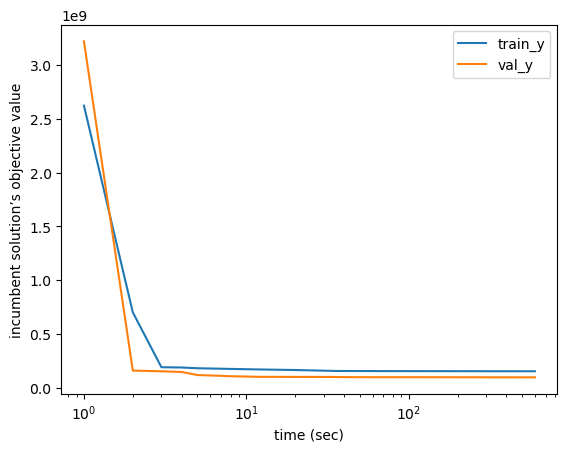

In [166]:
plt.plot(xnew, train_y, "-", label="train_y")
plt.plot(xnew, val_y, "-", label="val_y")
plt.xscale("log")
plt.xlabel("time (sec)")
plt.ylabel("Incumbent solution’s objective value")
plt.legend()
plt.show()

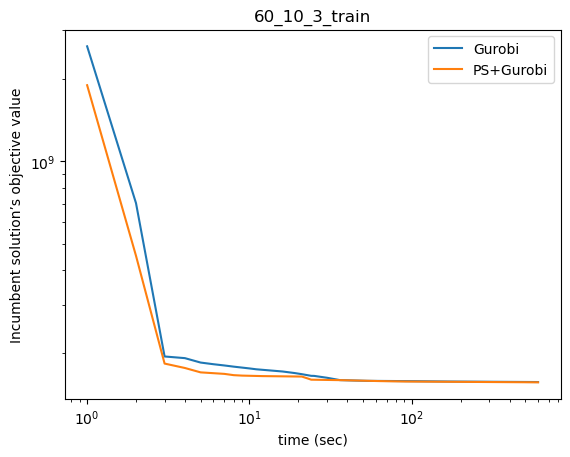

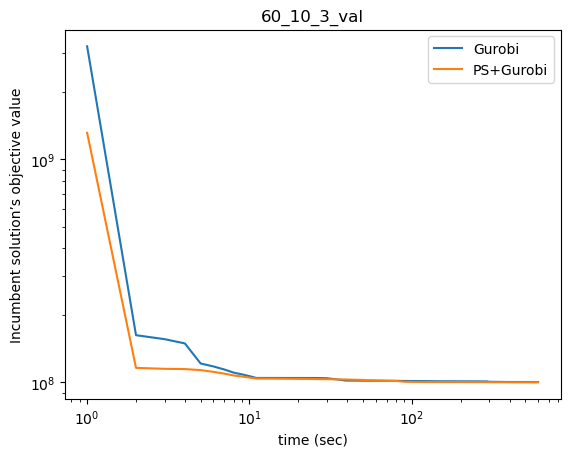

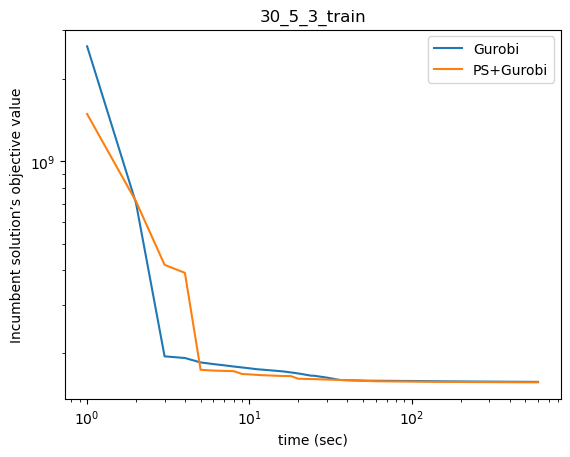

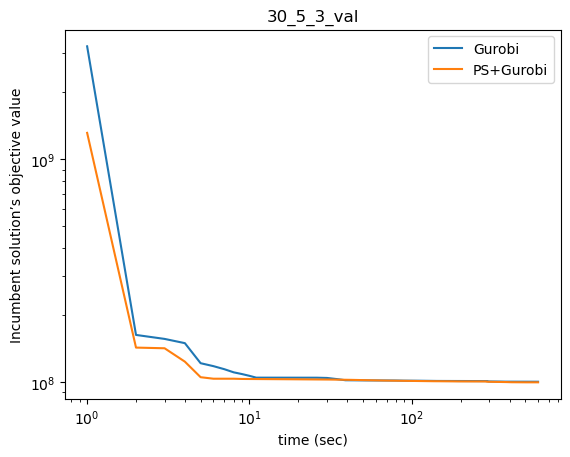

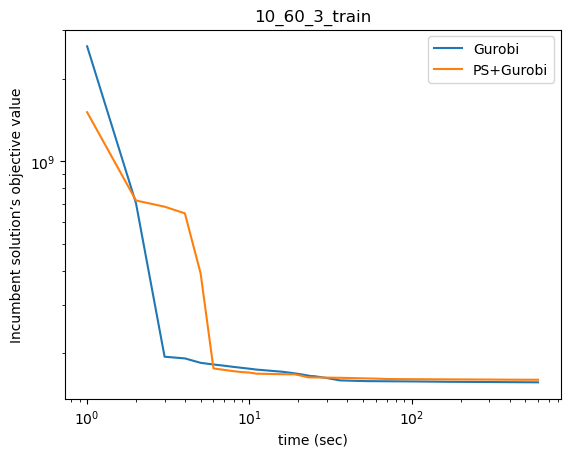

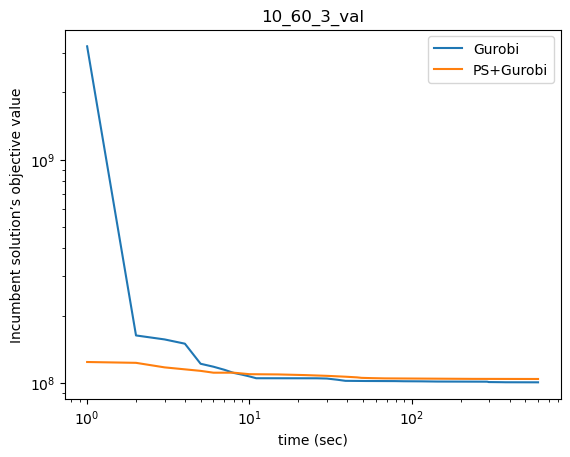

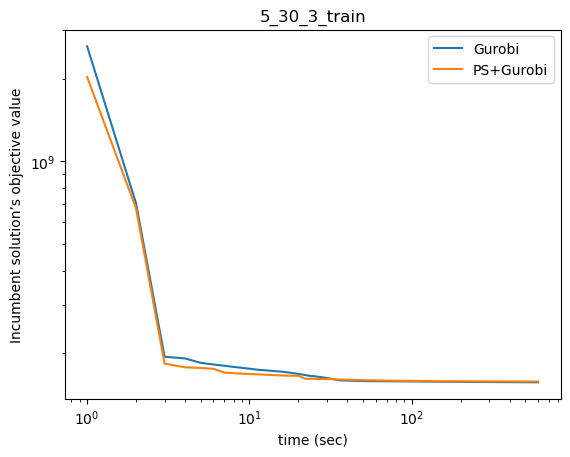

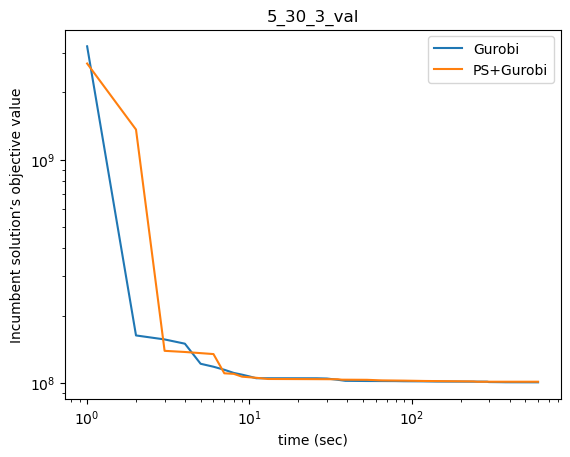

In [170]:
for par in params:
    for d_type in datatypes:
        plt.plot(xnew, y[d_type], "-", label="Gurobi")
        plt.plot(xnew, ys_dict[par][d_type], "-", label="PS+Gurobi")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("time (sec)")
        plt.ylabel("Incumbent solution’s objective value")
        plt.title(f"{par}_{d_type}")
        plt.legend()
        plt.show()

# histogram of each variable's value

In [1]:
import io
import os
import pickle
from glob import glob

import gurobipy as gp
import numpy as np
import torchimport torch

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "torch.storage" and name == "_load_from_bytes":
            return lambda b: torch.load(io.BytesIO(b), map_location="cpu")
        else:
            return super().find_class(module, name)

In [3]:
TaskName = "CJ/new"
ins_dir = f"/mnt/disk1/thlee/MILP/pas/instance/{TaskName}/train"
sol_dir = f"/mnt/disk1/thlee/MILP/pas/dataset/{TaskName}/train/solution"
bg_dir = f"/mnt/disk1/thlee/MILP/pas/dataset/{TaskName}/train/BG"

ins_names = sorted(os.listdir(ins_dir))
# sols_path = sorted(glob(f"{sol_dir}/*"))
# bgs_path = sorted(glob(f"{bg_dir}/*"))

In [5]:
for ins_name in ins_names:
    sol_path = f"{sol_dir}/{ins_name}.sol"
    # bg_path = f"{bg_dir}/{ins_name}.bg"

    with open(sol_path, "rb") as f:
        solData = pickle.load(f)
    # with open(bg_path, "rb") as f:
    #     bgData = CPU_Unpickler(f).load()
    # A, v_map, v_nodes, c_nodes, b_vars = bgData
    m = gp.read(f"{ins_dir}/{ins_name}")
    mvars = m.getVars()
    i_vars = [i.VarName for i in mvars if i.VType == "I"]
    break

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-20
Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S000.mps.gz
Reading time = 1.19 seconds
(null): 199866 rows, 124072 columns, 746370 nonzeros


In [7]:
v_map = {var_name: i for i, var_name in enumerate(solData["var_names"])}

In [8]:
var_idx = v_map[i_vars[1]]

In [19]:
var_idx += 1
solData["sols"][:, var_idx]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)

In [306]:
solData["sols"].shape

(65, 124072)

In [310]:
i_idxs = np.array([v_map[i] for i in i_vars])

In [327]:
x, y = np.unique(solData["sols"][:, i_idxs], return_counts=True)

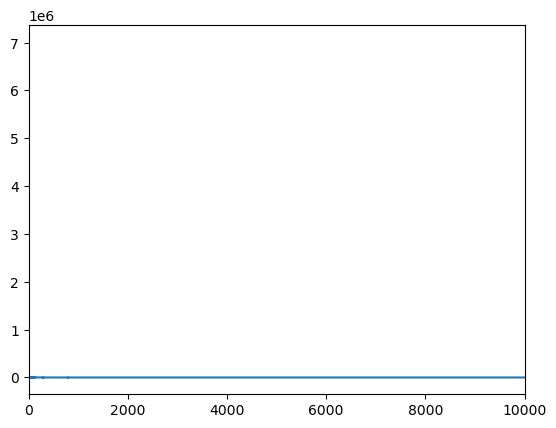

<Figure size 640x480 with 0 Axes>

In [345]:
plt.plot(x, y, "-", label="Gurobi")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("time (sec)")
# plt.ylabel("Incumbent solution’s objective value")
# plt.title(f"{par}_{d_type}")
# plt.legend()
plt.xlim([0, 10000])
plt.show()
plt.clf()

# Statistics of coefficient

In [1]:
import io
import os
import pickle
from glob import glob

import gurobipy as gp
import numpy as np
import torch

In [2]:
TaskName = "CJ/new"
ins_dir = f"/mnt/disk1/thlee/MILP/pas/instance/{TaskName}/train"
sol_dir = f"/mnt/disk1/thlee/MILP/pas/dataset/{TaskName}/train/solution"
bg_dir = f"/mnt/disk1/thlee/MILP/pas/dataset/{TaskName}/train/BG"

ins_names = sorted(os.listdir(ins_dir))
# sols_path = sorted(glob(f"{sol_dir}/*"))
# bgs_path = sorted(glob(f"{bg_dir}/*"))

In [26]:
rate_list, max_list, min_list, mean_list, std_list = [], [], [], [], []
for ins_name in ins_names:
    ins_path = f"{ins_dir}/{ins_name}"
    m = gp.read(ins_path)

    c_matrix = m.getA()
    sense = np.array(m.getAttr("Sense", m.getConstrs()))
    rhs = np.array(m.getAttr("RHS", m.getConstrs()))

    index_ge = np.where(sense == ">")[0]
    c_matrix[index_ge] *= -1
    rhs[index_ge] *= -1

    rate_ = (c_matrix.sum(axis=0) == 0).sum() / c_matrix.shape[1]

    rate_list.append(rate_ * 100)
    max_list.append(c_matrix.max())
    min_list.append(c_matrix.min())

    mean_list.append(c_matrix[(c_matrix != 0)].mean())
    std_list.append(c_matrix[(c_matrix != 0)].std())
    print(f"{ins_name} rate: {rate_ * 100}")

Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S000.mps.gz
Reading time = 0.35 seconds
(null): 199866 rows, 124072 columns, 746370 nonzeros
S000.mps.gz rate: 0.9333290347540139
Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S001.mps.gz
Reading time = 0.32 seconds
(null): 199818 rows, 127207 columns, 761519 nonzeros
S001.mps.gz rate: 0.9142578631679074
Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S002.mps.gz
Reading time = 0.33 seconds
(null): 199865 rows, 139089 columns, 842959 nonzeros
S002.mps.gz rate: 0.842625944539108
Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S003.mps.gz
Reading time = 0.31 seconds
(null): 199816 rows, 120949 columns, 726847 nonzeros
S003.mps.gz rate: 0.9698302590347998
Read MPS format model from file /mnt/disk1/thlee/MILP/pas/instance/CJ/new/train/S004.mps.gz
Reading time = 0.32 seconds
(null): 199763 rows, 130275 columns, 7818

In [27]:
print(np.mean(rate_list))
print(np.mean(max_list))
print(np.mean(min_list))
print(np.mean(mean_list))
print(np.mean(std_list))
print("good")

0.90499640654145
7000.0
-1500000.0
-112.49671139797978
4179.621046868429
good


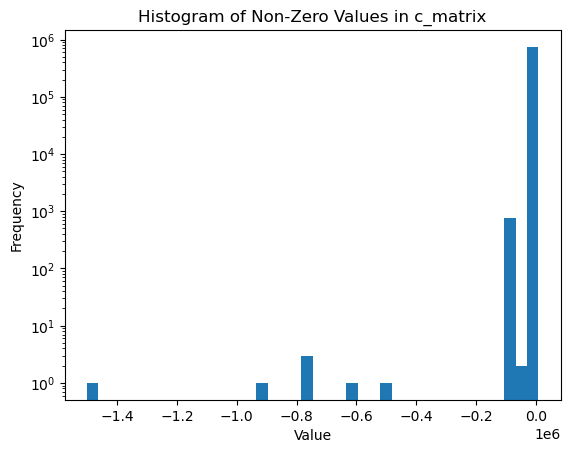

In [16]:
import matplotlib.pyplot as plt

# Get the non-zero values from c_matrix
non_zero_values = np.array(c_matrix[(c_matrix != 0)]).flatten()

# Create the histogram
plt.hist(non_zero_values, bins=40)

# Set the labels and title
plt.xlabel("Value")
plt.yscale("log")
plt.ylabel("Frequency")
plt.title("Histogram of Non-Zero Values in c_matrix")

# Show the histogram
plt.show()